In [2]:
from google.colab import files
files.upload()

Saving HumanActivityRecognition.zip to HumanActivityRecognition.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("HumanActivityRecognition.zip", 'r')
zip_ref.extractall("Human")
zip_ref.close()


In [4]:
# Importing the required libraries

import pandas as pd
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Defining Helper Functions

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
  
  
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the signals
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'Human/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))
  
  
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'Human/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()
  
  
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test
  
  
 # Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))
  
 

In [0]:
X_train, X_test, Y_train, Y_test = load_data() # Loading the train and test data

In [8]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# **Model - 1    With One LSTM Layer with 32 Neurons** 

In [9]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with softmax activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(lr = 0.001),metrics=['accuracy'])

# Declaring Callbacks

checkpoint = ModelCheckpoint("model_1.h5",monitor="val_loss",mode="min",save_best_only = True,verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]



# Training the model
model_1 = model.fit(X_train, Y_train, batch_size=64,validation_data=(X_test, Y_test),epochs=50,callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 36s 5ms/step - loss: 1.3435 - acc: 0.4396 - val_loss: 1.1980 - val_acc: 0.4625

Epoch 00001: val_loss improved from inf to 1.19797, saving model to model_1.h5
Epoch 2/50
7352/7352 [==============================] - 34s 5ms/step - loss: 1.0503 - acc: 0.5522 - val_loss: 1.0647 - val_acc: 0.5453

Epoch

Test Score: 0.290512
Test Accuracy: 89.752290%


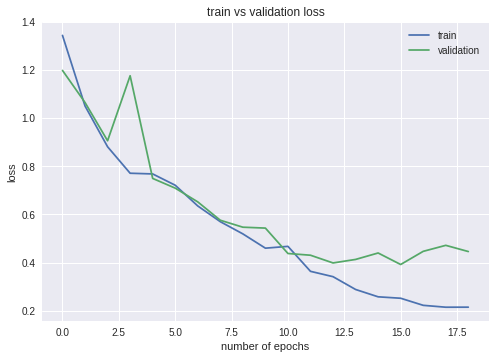

In [21]:
import matplotlib.pyplot as plt

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))


# plot train and validation loss

plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [18]:
# Predictions

Y_predictions = model.predict(X_test)



# Confusion Matrix

model_1_cm = confusion_matrix(Y_test,Y_predictions)
model_1_cm

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,0,374,109,2,0,6
STANDING,0,86,439,2,2,3
WALKING,1,0,0,446,42,7
WALKING_DOWNSTAIRS,0,0,0,13,373,34
WALKING_UPSTAIRS,0,0,1,18,38,414


# **Model -2  With Two LSTM Layers and 64 Neurons**

In [26]:
# Initiliazing the sequential model
model_2 = Sequential()
# Configuring the parameters
model_2.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model_2.add(Dropout(0.7))

# Configuring the parameters
model_2.add(LSTM(64))
# Adding a dropout layer
model_2.add(Dropout(0.7))
# Adding a dense output layer with softmax activation
model_2.add(Dense(n_classes, activation='softmax'))
model_2.summary()

# Compiling the model
model_2.compile(loss='categorical_crossentropy',optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['accuracy'])

# Declaring Callbacks

checkpoint = ModelCheckpoint("model_2.h5",monitor="val_loss",mode="min",save_best_only = True,verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# Training the model
model_two = model_2.fit(X_train,Y_train,batch_size=64,validation_data=(X_test, Y_test),epochs=50,callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 69s 9ms/step - loss: 1.2688 - acc:

Test Score: 0.508556
Test Accuracy: 87.343061%


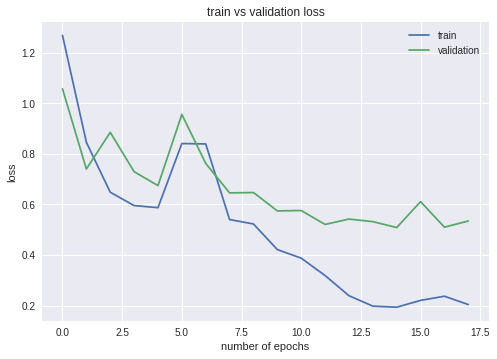

In [27]:
scores_2 = model_2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores_2[0]))
print("Test Accuracy: %f%%" % (scores_2[1]*100))


# plot train and validation loss

plt.plot(model_two.history['loss'])
plt.plot(model_two.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [28]:
# Predictions

Y_predictions = model_2.predict(X_test)



# Confusion Matrix

model_2_cm = confusion_matrix(Y_test,Y_predictions)
model_2_cm

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,0,371,95,3,0,22
STANDING,0,74,442,12,0,4
WALKING,0,0,0,451,2,43
WALKING_DOWNSTAIRS,0,0,0,26,394,0
WALKING_UPSTAIRS,0,0,0,60,5,406


# **Comparing Model Performance**

In [29]:
from prettytable import PrettyTable


name = ["Model 1","Model 2"]
train_acc = [max(model_1.history['acc']),max(model_two.history['acc'])]

test_acc =[scores[1],scores_2[1]]
             
numbering = [1,2]
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",name)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)
print(ptable)

+-------+---------+-------------------+--------------------+
| S.NO. |  MODEL  | Training Accuracy |   Test Accuracy    |
+-------+---------+-------------------+--------------------+
|   1   | Model 1 | 0.933895538823519 | 0.8975229046487954 |
|   2   | Model 2 | 0.936207834537971 | 0.8734306073973532 |
+-------+---------+-------------------+--------------------+
